<a href="https://colab.research.google.com/github/JacobaCarr26/comp215/blob/main/Copy_of_lab04_more_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 4
----------------
#### Name: Jacoba Carr
#### Date: 2025-01-29

By the end of this lab you should be able to:
  * use composition and inheritance in a `class` to categorize related information


During this lab, you will be introduced to the following:
  * something, something



## Near Earth Objects (with more classes)

We'll continue working with Near Earth Object data using NASA's API: https://api.nasa.gov/.  In Lab 3 we defined an Asteroid class that contained a simple data structure.  In this lab, we will be Here's a brief review from Lab 2 on how to use the API.  

In [1]:
# import necessary modules
import datetime, json, requests, math
from pprint import pprint

### Review: make an API query

Here's a query that gets the record for a single NEO that recently passed by.

In [2]:
from google.colab import userdata # Can actually use colab and not dotenv
API_KEY = userdata.get('API_KEY')

def get_neos(start_date):
    """ Return a list of NEO for the week starting at start_date """
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&api_key={API_KEY}'
    # Fetch last week's NEO feed
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    #pprint(data)
    print(f'{data["element_count"]} Near Earth Objects found for week of {start_date}')
    return [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records ]

def get_neo(id):
    """ Return a NEO record for the given id """
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    return json.loads(response.text)

from datetime import datetime, timedelta
today = datetime.now()
week_start = today - timedelta(weeks=1)
# Format today and one week ago to start and end
start = week_start.strftime("%Y-%m-%d")
end = today.strftime("%Y-%m-%d")

neos = get_neos(start)
assert len(neos) > 0, f'Oh oh!  No NEOs found for {start}'
neo = get_neo(neos[-1]['id'])  # get the very latest NEO
#print(f"Record for NEO ID {neos[-1]['id']} is:")
#pprint(neo)

92 Near Earth Objects found for week of 2025-01-23


## Exercise 1: Define a CloseApproach class

Each NEO record comes with a list of `close_approach_data`, where each record in this list represents a single “close approach” to another orbiting body.
1. Develop a class named `CloseApproach` to represent a single close approach record.  State variables are

        neo (refrence to related NEO object)
        orbiting body (str)
        approach date (datetime object!)
        miss distance (float - choose units, document it, and be consistent!)
        relative velocity (ditto)
  
2. Define a "Factory" class method to construct a `CloseApproach` object from one close approach data record (a dictionary object). This method takes a `neo` object as input for the NEO to which the close approach data belongs. Remember to parse the date/time string into a datetime object.

In [3]:
# Ex. 1
from dataclasses import dataclass

@dataclass
class CloseApproach:
  neo_id: str
  orbiting_body: str
  approach_date: datetime
  miss_distance: float  # Use km
  relative_velocity: float  # Use km/s

  @classmethod
  def from_NEO(cls, neo_id, approach_data):
    '''Factory method to create a CloseApproach from an NEO object and a single close approach record.

    - 'miss_distance' is stored in 'kilometers'.
    - 'relative_velocity' is stored in 'kilometers_per_second'.
    '''
    return cls(
      neo_id=neo_id,
      orbiting_body=approach_data['orbiting_body'],
      approach_date=datetime.strptime(approach_data['close_approach_date'], '%Y-%m-%d'),
      miss_distance=float(approach_data['miss_distance']['kilometers']),
      relative_velocity=float(approach_data['relative_velocity']['kilometers_per_second'])
    )


In [4]:
import unittest

class TestCloseApproach(unittest.TestCase):
  def setUp(self):
    '''Set up a sample NEO object and close approach data for testing.'''
    self.neo_id = {'neo_reference_id': '54517678'}  # Simulating an NEO object using ID from the most recent NEO
    self.approach_data = {
      'orbiting_body': 'Earth',
      'close_approach_date': '2029-04-13',
      'miss_distance': {'kilometers': '32000.0'},
      'relative_velocity': {'kilometers_per_second': '7.42'}
    }

  def test_from_NEO(self):
    '''Test the factory method 'from_NEO'.'''
    approach = CloseApproach.from_NEO(self.neo_id['neo_reference_id'], self.approach_data)

    # Check the type of the created object
    self.assertIsInstance(approach, CloseApproach)

    # Check the stored values
    self.assertEqual(approach.neo_id, self.neo_id['neo_reference_id'])
    self.assertEqual(approach.orbiting_body, 'Earth')
    self.assertEqual(approach.approach_date, datetime(2029, 4, 13))  # Ensure date parsing works
    self.assertAlmostEqual(approach.miss_distance, 32000.0)  # Float comparison
    self.assertAlmostEqual(approach.relative_velocity, 7.42)

# Run the tests
unittest.main(argv=[''], exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.009s

OK


## Exercise 2: Add list of CloseApproach objects to the Asteroid

Define an `Asteroid` class, like you did in Lab 3, but give the `Asteroid` list of “close approaches”.  This is called *composition* because each Asteroid object will be *composed* of CloseApproach objects (plus some other things).  There is bit of a catch-22 here because we need the `Asteroid` to construct the `CloseApproach` objects. The first two steps deal with that:

1. Add an instance variable to your Asteroid class with a default value of an empty list:

    ```
    close_approaches:list = []
    ```
      
2. In the Asteroid `from_NEO` factory, use a list comprehension to build the list of `CloseApproach` objects for the Asteroid instance, and then set the instance's `close_approaches` variable before returning it. Setting the value of an object's instance variables from outside the class is generally frowned upon - this is why we make the factory a method of the class itself.

3. Add a method to `Asteroid` to return the `CloseApproach` object for the nearest miss (ie. smallest `missed_distance`):
    ```
    def nearest_miss(self):
        ...
    ```

4. Add a method to the Asteroid class, `closest_earth_approach`, that returns the CloseApproach object that represents the closest approach the Asteroid makes to Earth.
    ```
    def closest_earth_approach(self):
        ...
    ```

Write some test code to demonstrate these new features.

In [5]:
# Ex. 2
@dataclass
class Asteroid:
  id: str
  name: str
  estimated_diameter: float
  is_potentially_hazardous: bool
  close_approaches: list

  @classmethod
  def from_NEO(cls, neo_id):
    '''Factory method to create an Asteroid from an NEO ID.'''
    neo = get_neo(neo_id)

    # List comprehension to create CloseApproach objects
    close_approaches = [
      CloseApproach.from_NEO(neo, approach_data)
      for approach_data in neo.get('close_approach_data', [])
    ]

    return cls(
      id=neo['id'],
      name=neo['name'],
      estimated_diameter=neo['estimated_diameter']['meters']['estimated_diameter_max'],
      is_potentially_hazardous=neo['is_potentially_hazardous_asteroid'],
      close_approaches=close_approaches  # Assign the list we made
    )

  def nearest_miss(self):
    '''Returns the CloseApproach object with the smallest miss distance.'''
    if not self.close_approaches:
      return None  # Means no close approaches

    return min(self.close_approaches, key=lambda ca: ca.miss_distance)

  def closest_earth_approach(self, start_date=None, end_date=None):
    '''Find the closest approach within an optional date range.'''
    # Convert start and end dates to datetime objects if provided
    start_dt = datetime.strptime(start_date, "%Y-%m-%d") if start_date else None
    end_dt = datetime.strptime(end_date, "%Y-%m-%d") if end_date else None

    # Filter approaches that are within the requested date range
    valid_approaches = [
      approach for approach in self.close_approaches
      if (not start_dt or approach.approach_date >= start_dt) and
        (not end_dt or approach.approach_date <= end_dt)
    ]

    # Return the closest valid approach
    return min(valid_approaches, key=lambda x: x.miss_distance, default=None)



In [6]:
from unittest.mock import patch

class TestAsteroid(unittest.TestCase):
  def setUp(self):
    '''Set up a sample Asteroid with multiple CloseApproach objects.'''
    self.fake_neo = {
      'id': '2029_APO',
      'name': 'Apophis',
      'estimated_diameter': {'meters': {'estimated_diameter_max': 370.0}},
      'is_potentially_hazardous_asteroid': True,
      'close_approach_data': [
        {'orbiting_body': 'Earth', 'close_approach_date': '2029-04-13',
          'miss_distance': {'kilometers': '32000.0'},
          'relative_velocity': {'kilometers_per_second': '7.42'}},

        {'orbiting_body': 'Mars', 'close_approach_date': '2030-06-22',
          'miss_distance': {'kilometers': '500000.0'},
          'relative_velocity': {'kilometers_per_second': '10.1'}},

        {'orbiting_body': 'Earth', 'close_approach_date': '2040-07-15',
          'miss_distance': {'kilometers': '25000.0'},
          'relative_velocity': {'kilometers_per_second': '8.2'}}
        ]
      }

  def test_nearest_miss(self):
    '''Test that 'nearest_miss' returns the correct CloseApproach.'''
    with patch('__main__.get_neo', return_value=self.fake_neo):
      asteroid = Asteroid.from_NEO("2029_APO")
      closest = asteroid.nearest_miss()
      self.assertIsNotNone(closest)
      self.assertEqual(closest.miss_distance, 25000.0)  # Closest approach

  def test_closest_earth_approach(self):
    '''Test that 'closest_earth_approach' returns the closest approach to Earth.'''
    with patch('__main__.get_neo', return_value=self.fake_neo):
      asteroid = Asteroid.from_NEO("2029_APO")
      closest_earth = asteroid.closest_earth_approach()
      self.assertIsNotNone(closest_earth)
      self.assertEqual(closest_earth.miss_distance, 25000.0)  # Closest Earth approach

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.018s

OK


## Exercise 3: Plot the Closest Approaches

Write a function that takes an Asteroid object as a parameter and makes a timeline plot of close approaches.  You may wish to use the `matplotlib.pyplot` `plot` object.  Here is an example of a timeline plot for the asteroid with neo id '54339874'

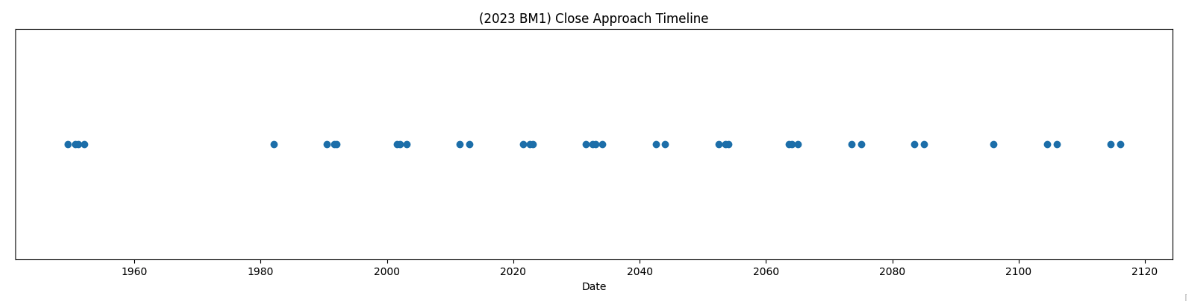

In [7]:
# Ex. 3
import matplotlib.pyplot as plt

def plot_close_approaches(asteroid):
  '''Plots a timeline of close approaches, ignoring miss distance.'''
  if not asteroid.close_approaches:
    print("No close approaches to plot.")
    return

  # Extract years from the approach dates
  years = [ca.approach_date.year for ca in asteroid.close_approaches]

  # Adjust years so 1940 is "year 0" - just because the example graph is like this
  adjusted_years = [year - 1940 for year in years]

  # Set a constant y-value to keep all points on a straight line
  y_values = [1] * len(adjusted_years)

  # Create the plot
  plt.figure(figsize=(13, 2.75))
  plt.scatter(adjusted_years, y_values, color='#1e77b4', marker='o', s=15)

  # Formatting
  plt.xlabel("Date", fontsize=6.5)
  plt.title(f"{asteroid.name} Close Approach Timeline", fontsize=8)

  # X-axis ticks every 20 years from 1960 to 2120
  plt.xticks(ticks=range(20, 181, 20), labels=range(1960, 2121, 20), fontsize=6.5)

  # Hide y-axis labels since they are meaningless
  plt.yticks([])

  plt.grid(False)  # No grid

  plt.show()


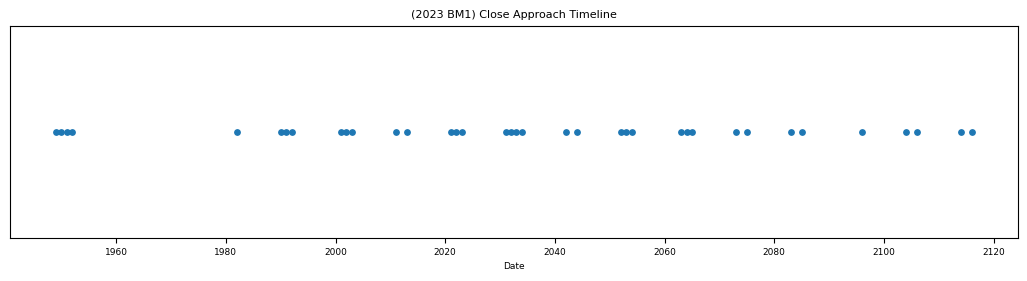

In [8]:
plot_close_approaches(Asteroid.from_NEO("54339874"))

## Challenge - Take your skills to the next level...

 With these data structures in place, we can now start answering all kinds of interesting questions about a single Asteroid or a set of Asteroids.  
Here’s a couple ideas to try:



* write a **function** named `most_dangerous_approach`, that takes a date range and returns a single “potentially hazardous” Asteroid object that makes the closest approach to Earth in within that range.  Your algorithm will ultimately need to:
    * grab the list of NEO’s for the given date range;
    * use a list comprehension to build the list of Asteroid objects for the NEO’s returned
    * use a list comprehension to filter  potentially hazardous Asteroids only;
    * use a list comprehension to map each Asteroid to its  closest_earth_approach
    * apply Python’s min function to identify the Asteroid with the closest_earth_approach

You may want to decompose some of these steps into smaller functions.
* add a method to the Asteroid class, estimated_mass, that computes an estimate of the Asteroid’s mass based on its diameter.  This is a model – state your assumptions.
* add a method to the CloseApproach class, impact_force,  that estimates the force of impact if the Asteroid hit the orbiting object.  Again, this is a model, state your assumptions.

In [20]:
# Too much trouble associated with creating the two new methods, so I just made the most_dangeroud_approach function
# Ex. 4 (challenge)

def get_neos_in_range(start_date, end_date):
  ''' returns a list of NEO data from the API

  preconditions: start_date and end_date are in format: YYYY-MM-DD
  '''
  url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&end_date={end_date}&api_key={API_KEY}'
  # Fetch NEO feed within date range
  response = requests.request("GET", url, headers={}, data={})
  data = json.loads(response.text)
  return [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records ]


def most_dangerous_approach(start_date, end_date):
  ''' takes a date range and returns the neo with the most dangerous approach

  preconditions: start_date and end_date are in format: YYYY-MM-DD
  postconditions: returns the full Asteroid object with the most dangerous approach

  user should only print desired attributes of the asteroid object to prevent overload
  '''
  # Assume 'get_neos_in_date_range' returns a list of NEO data from an API or file
  neos_in_range = get_neos_in_range(start_date, end_date)

  # Build Asteroid objects
  asteroids = [Asteroid.from_NEO(neo['id']) for neo in neos_in_range if Asteroid.from_NEO(neo['id']).is_potentially_hazardous]

  # Find closest Earth approach for each asteroid
  closest_approaches = [
    (asteroid, asteroid.closest_earth_approach(start_date, end_date)) for asteroid in asteroids
  ]
  closest_approaches = [entry for entry in closest_approaches if entry[1] is not None]
  if not closest_approaches:
    return None

  # Use min to find the asteroid with the closest approach
  most_dangerous = min(closest_approaches, key=lambda x: x[1].miss_distance)

  return most_dangerous[0]  # Return the Asteroid object

In [21]:
# Test for the first week of this month
dangerous_asteroid = most_dangerous_approach('2025-01-01','2025-01-08')
print(f"Most dangerous asteroid: {dangerous_asteroid.name}")
print(f"Miss distance: {dangerous_asteroid.closest_earth_approach().miss_distance}km")

Most dangerous asteroid: (2020 BC6)
Miss distance: 1821501.884905347km
